# Baseline 2-Staged Least Squares Instrumental Variables Regression using Cornelia's Randomized Medical Data

In [1]:
# optional. I'm getting annoying warnings that I just want to ignore:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# basics
import pandas as pd 
import numpy as np
import os 
import re
from datetime import datetime
from tqdm.notebook import tqdm
tqdm.pandas()
import requests
import urllib

# plotting
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import plotly.express as px
import seaborn as sns

# modeling
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.sandbox.regression.gmm import IV2SLS

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [2]:
# download this extra package from here: https://github.com/bashtage/linearmodels
#!pip install linearmodels
from linearmodels.iv import IV2SLS as IV2SLS_v2

In [3]:
# local or gdrive
path_source = 'local'

if path_source == 'gdrive':
  from google.colab import drive
  drive.mount('/content/gdrive')
  data_path = '/content/gdrive/MyDrive/Classes/W210_capstone/W210_Capstone/Data'
  #env_path = '/content/gdrive/MyDrive/.env'
  
elif path_source == 'local':
  data_path = '/Users/tj/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/Data'
  #env_path = '/content/gdrive/MyDrive/.env'

elif path_source == 'work':
  data_path = '/Users/trevorjohnson/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/Data'

# Read in data

In [4]:
# read in our modeling data
df = pd.read_csv(os.path.join(data_path, 'modeling_data/modeling_data_2022-10-16.csv'))

# read in cornelia's healthcare data
df1 = pd.read_csv(os.path.join(data_path, 'medical/hematopoietic_cancers.csv')).iloc[:,1:]
df2 = pd.read_csv(os.path.join(data_path, 'medical/pediatric_vasculitis.csv')).iloc[:,1:]
df3 = pd.read_csv(os.path.join(data_path, 'medical/type_1_diabetes.csv')).iloc[:,1:]

# Data clean

Clean med data

In [5]:
# get all distinct patzip_year_month
all_pats = df1['patzip_year_month'].to_list() + df2['patzip_year_month'].to_list() + df3['patzip_year_month'].to_list()
all_pats = list(set(all_pats))
df_med = pd.DataFrame({'patzip_year_month': all_pats})

# rename columns more intuitively
df1 = df1.rename(columns={'number_of_visits': 'number_of_visits_hem_cancers'})
df2 = df2.rename(columns={'number_of_visits': 'number_of_visits_vasc'})
df3 = df3.rename(columns={'number_of_visits': 'number_of_visits_diab'})

# now join all the diagnoses on this dataset
df_med = df_med\
  .merge(df1, on='patzip_year_month', how='left')\
  .merge(df2, on='patzip_year_month', how='left')\
  .merge(df3, on='patzip_year_month', how='left')

df_med.head(3)

,patzip_year_month,hematopoietic_cancers,number_of_visits_hem_cancers,pediatric_vasculitis,number_of_visits_vasc,type_1_diabetes,number_of_visits_diab
0,95135-2012-7,NaN,NaN,1.0,17.0,NaN,NaN
1,93422-2017-1,1.0,17.0,1.0,18.0,NaN,NaN
2,95833-2017-2,NaN,NaN,1.0,17.0,NaN,NaN


Join med data

In [6]:
df['year_month'] = df['year_month'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))

df['zip_year_month'] = df['school_zip'].astype(str) + '-' +\
  df['year_month'].dt.year.astype(str) + '-' +\
  df['year_month'].dt.month.astype(str)

df = pd.merge(df, df_med, left_on='zip_year_month', right_on='patzip_year_month', how='left')

# for missing med data, assume there were 0 cases:
med_vars = ['hematopoietic_cancers', 'number_of_visits_hem_cancers', 'pediatric_vasculitis', 
  'number_of_visits_vasc', 'type_1_diabetes', 'number_of_visits_diab']
for var in med_vars:
  df[var] = df[var].fillna(0)

# fixing month datatype
df['month'] = df['month'].astype(str)

print(df.shape[0])

312345


Var transformations

In [7]:
# Create response variables, which is visits / population
df['y_hematopoietic'] = df['number_of_visits_hem_cancers'] / df['total_pop_under19']
df['y_vasculitis'] = df['number_of_visits_vasc'] / df['total_pop_under19']
df['y_diabetes'] = df['number_of_visits_diab'] / df['total_pop_under19']

# Make treatment var normally distributed by taking log(1+x)
df['pm25_log'] = np.log1p(df['pm25'])

Define all variables we'll be using

In [8]:
# X vars
#x_wind = ['school_wspd', 'ps_wspd_merge', 'avg_wind_speed']
x_wind = ['school_wspd', 'ps_wspd_merge']
x_elevation = ['school_elevation_m', 'ps_elevation_m']
x_population = [i for i in df.columns if (re.search('population_', i) and re.search('male', i))] # + ['pop_under19_male', 'pop_under19_female']
x_socioecon = ['ca_agi_per_returns', 'tax_liability_per_capita']
x_temp = ['school_temperature', 'ps_temperature']
x_window = ['pm25_last_month'] + [i for i in df.columns if re.search('pm25_r.', i)] + [i for i in df.columns if re.search('pm25_slope', i)] + ['pm25_lag_12mo']
x_other = ['nearby_point_source_count', 'school_count', 'point_source_pm25_tpy']
x_time = ['year'] + [i for i in df.columns if (re.search('month_', i) and i not in 'month_01')]
x_region = [i for i in df.columns if (re.search('school_region_name_', i) and i not in 'school_region_name_los_angeles_county')]
# vars I dont think we can use:
#point_source_pm25_tpy
x_all = x_wind + x_elevation + x_population + x_socioecon + x_temp + x_window + x_other + x_time + x_region
x_vars_for_tree_model = x_wind + x_elevation + x_population + x_socioecon + x_temp + x_window + x_other + ['year', 'month', 'school_region_name']

other_vars_to_keep = ['month_01', 'school_region_name_los_angeles_county', 'month', 'school_region_name']

instrument = ['avg_wind_alignment_cosine']

y_pm25_log = ['pm25_log']
y_pm25 = ['pm25']

y_hema = ['y_hematopoietic']
y_vasc = ['y_vasculitis']
y_diab = ['y_diabetes']

all_vars_to_keep = list(set(x_all + other_vars_to_keep + instrument + y_pm25_log + y_pm25 + y_hema + y_vasc + y_diab))

Select only necessary columns, and remove all NA values

In [9]:
# get complete data
print(f'num rows to start: {df.shape[0]}')

df_modeling = df[all_vars_to_keep]

for var in df_modeling.columns:
  df_modeling = df_modeling[~df_modeling[var].isna()]

print(f'num rows after filtering: {df_modeling.shape[0]}')

num rows to start: 312345
num rows after filtering: 277875


# EDA

Plotting all diseases in 1 graph is too hard to see anything. Since when one is positive, the others are usually 0. 

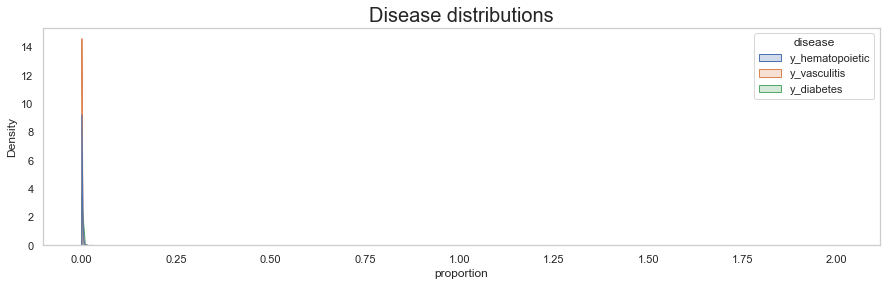

In [10]:
df_melt = pd.melt(df_modeling, 
              value_vars=['y_hematopoietic', 'y_vasculitis', 'y_diabetes'], 
              var_name='disease', value_name='proportion')
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df_melt, x="proportion", hue='disease', bw_adjust=.8, fill=True)\
  .set_title("Disease distributions", size=20)
print('')

When looking at positive diagnoses, it's still too hard to visualize anything.

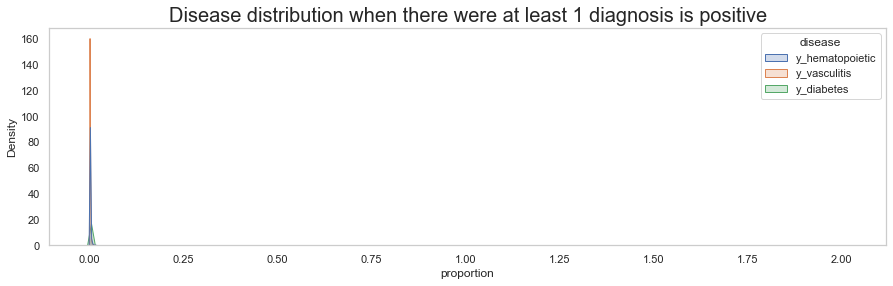

In [11]:
df_melt = pd.melt(df_modeling[df_modeling['y_hematopoietic'] + df_modeling['y_vasculitis'] + df_modeling['y_diabetes'] > 0], 
              value_vars=['y_hematopoietic', 'y_vasculitis', 'y_diabetes'], 
              var_name='disease', value_name='proportion')
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df_melt, x="proportion", hue='disease', bw_adjust=.8, fill=True)\
  .set_title("Disease distribution when there were at least 1 diagnosis is positive", size=20)
print('')

Plots of each diagnosis individually, positive observations only, log scaled. 

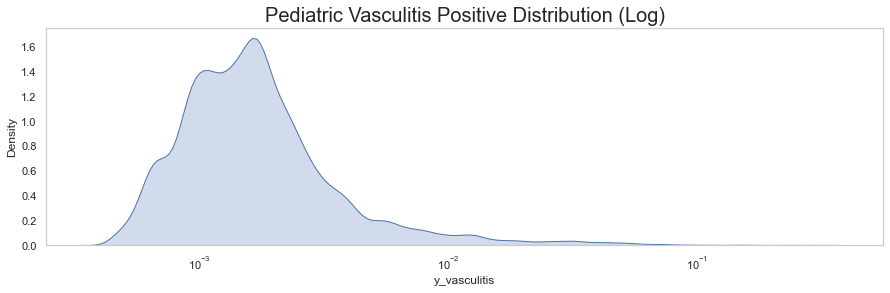

In [12]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df_modeling[df_modeling['y_vasculitis']>0], x="y_vasculitis", bw_adjust=.8, fill=True, log_scale=True)\
  .set_title("Pediatric Vasculitis Positive Distribution (Log)", size=20)
print('')

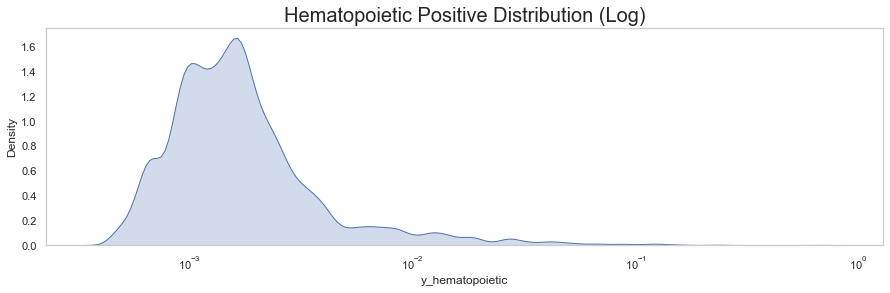

In [13]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df_modeling[df_modeling['y_hematopoietic']>0], x="y_hematopoietic", bw_adjust=.8, fill=True, log_scale=True)\
  .set_title("Hematopoietic Positive Distribution (Log)", size=20)
print('')

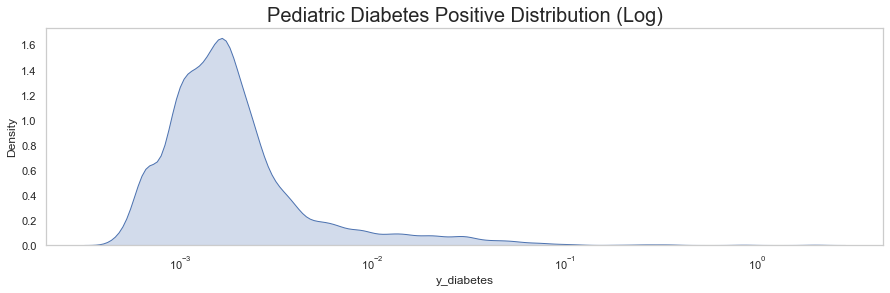

In [14]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df_modeling[df_modeling['y_diabetes']>0], x="y_diabetes", bw_adjust=.8, fill=True, log_scale=True)\
  .set_title("Pediatric Diabetes Positive Distribution (Log)", size=20)
print('')

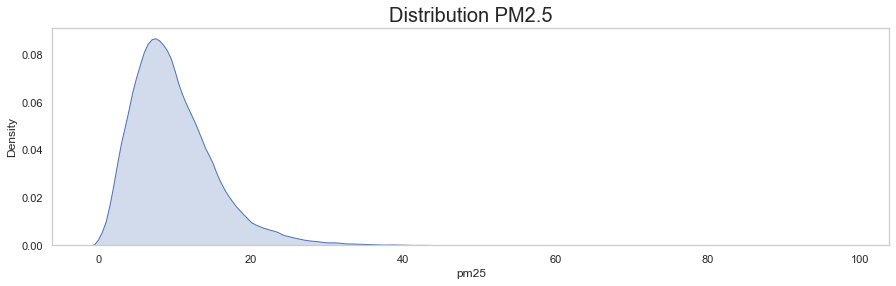

In [15]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df_modeling, x="pm25", bw_adjust=.8, fill=True).set_title("Distribution PM2.5", size=20)
print('')

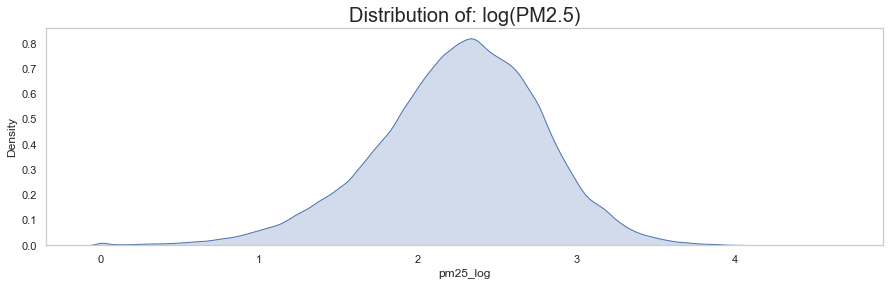

In [16]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df_modeling, x="pm25_log", bw_adjust=.8, fill=True)\
  .set_title("Distribution of: log(PM2.5)", size=20)
print('')

Univariate analysis

In [17]:
class FeatureStats:
  
  def __init__(self, df):
    self.df = df


  # method to get linear reg stats from any continuous feature
  def num_var_analyze(self, var, yvar='pm25'):
  
    df1 = self.df[[var, yvar]]
    
    # % missing
    percent_missing = df1[var].isna().sum() / df1.shape[0]
    
    # median impute
    df1[var] = df1[var].fillna(df1[var].median())
    
    # get lm metrics
    lm_model = LinearRegression() 
    lm_model.fit(X = df1[[var]], y=df1[yvar])
    yhat = lm_model.predict(df1[[var]])
    beta = lm_model.coef_[0]
    intercept = lm_model.intercept_
    ss_resid = sum((yhat - df1[yvar].values)**2)
    ss_total = sum((df1[yvar].mean() - df1[yvar].values)**2)
    r_squared = 1 - ss_resid / ss_total 
    
    output = {'var': [var], 'percent_missing': [percent_missing], 'beta': [beta], 'r_squared': [r_squared], 'intercept': [intercept]}
    return output
  
  
  def sort_num_features(self, var_list, yvar='pm25'):
    res_all = {}
    for var in var_list:
      res_i = self.num_var_analyze(var)
      
      if len(res_all) == 0:
        res_all = res_i.copy()
      else:
        for metric in ['var', 'percent_missing', 'beta', 'r_squared', 'intercept']:
          res_all[metric].append(res_i[metric][0])
    
    df_res = pd.DataFrame(res_all)
    df_res = df_res.sort_values('r_squared', ascending=False)
    
    return df_res
  
  
  def plot_num_features(self, var_list, yvar='pm25', show_missing_percent=False):
    
    ncol=2
    nrow = int(len(var_list) / ncol) + 1
    
    fig, ax = plt.subplots(nrow,ncol, figsize=(10*ncol, 5*nrow))
    
    # sort num features by r-squared
    sorted_features = self.sort_num_features(var_list)
    var_list = sorted_features['var'].to_list()
    
    var_i = 0
    for i in range(nrow):
      for j in range(ncol):
        
        if var_i+1 > len(var_list):
          break 
        
        var = var_list[var_i]
        
        # clean data
        df1 = self.df[[var, yvar]]
        df1[var] = df1[var].fillna(df1[var].median())
        
        # get regression details
        reg_results = self.num_var_analyze(var)
        
        # plot scatter 
        ax[i][j].scatter(df1[var], df1[yvar], alpha=.3, color='#3d7aba') # #f70eaa = lyft color
        
        # plot line
        xseq = np.linspace(df1[var].min(), df1[var].max(), num=100)
        yseq = reg_results['intercept'][0] + reg_results['beta'][0] * xseq
        xseq = xseq[yseq > 0]
        yseq = yseq[yseq > 0]
        ax[i][j].plot(xseq, yseq, color='k', lw=2.5)
        
        # set title
        if show_missing_percent:
          title_text = '{} | % missing: {:.2f} | beta: {:.1f} | $r^2$: {:.4f}'.format(
            var, reg_results['percent_missing'][0], reg_results['beta'][0], reg_results['r_squared'][0])
        else:
          title_text = '{} | beta: {:.1f} | $r^2$: {:.4f}'.format(var, reg_results['beta'][0], reg_results['r_squared'][0])
        
        ax[i][j].title.set_text(title_text)
        
        var_i += 1
    
    return fig.tight_layout()
  
  
  def cat_var_analyze(self, var, yvar='pm25', max_factor_levels = 10):
    
    df1 = self.df[[var, yvar]]
    
    df_plt = df1.copy()
    
    # if it's numeric and has more than 10 factor levels, bin it into [bracketed] bins
    if ((df_plt[var].dtypes == 'int') | (df_plt[var].dtypes == 'float')) & (len(set(df_plt[var])) > max_factor_levels):
      # give the intervals better names that start with a number
      res = pd.qcut(df_plt[var], q=max_factor_levels, precision=2, duplicates='drop').to_list()
      res_distinct = list(set(res))
      res_distinct.sort()
      res_string = [str(i) for i in res_distinct]
      res_string = [str(i).rjust(2,'0')+'_'+var for i, var in enumerate(res_string)]
      res_mapping = {x:y for x,y in zip(res_distinct, res_string)}
      res2 = [res_mapping[i] for i in res]
      # df_plot[var] = pd.cut(df_plot[var], bins=max_factor_levels, precision=2).to_list()
      df_plt[var] = res2
      df1 = df_plt.copy()
    
    df1[var] = df1[var].astype(str)

    def count_missing(var):
      num_na = df1[var].isna().sum()
      num_unknown = df1[var].map(lambda x: bool(re.search('unknown|no_data|missing', x.lower()))).sum()
      total_na = num_na + num_unknown
      
      return total_na
    
    # % missing
    percent_missing = count_missing(var) / df1.shape[0]
    
    # impute missing
    df1[var] = df1[var].fillna('missing')
    
    # one hot encode
    df1 = pd.get_dummies(df1)
    
    # rename columns
    #df1.columns = df1.columns.str.replace("\.*\s+", "_").str.lower()
    
    # run a linear reg
    X = df1.iloc[:,1:]
    X = sm.add_constant(X)
    y = df1[yvar]
    lm_fit = sm.OLS(y, X).fit() 
    lm_summary = lm_fit.summary()
    aic_ = lm_fit.aic
    bic_ = lm_fit.bic
    
    # save results 
    output = {'var': [var], 'percent_missing': [percent_missing], 'aic': [aic_], 'bic': [bic_]}
    return output
    
  
  def sort_cat_features(self, var_list, yvar='pm25', max_factor_levels = 10, sort_by='aic', verbose=False):
    res_all = {}
    for var in var_list:
      if verbose:
        print(var)
        
      res_i = self.cat_var_analyze(var, yvar=yvar, max_factor_levels=max_factor_levels)
      
      if len(res_all) == 0:
        res_all = res_i.copy()
      else:
        for metric in ['var', 'percent_missing', 'aic', 'bic']:
          res_all[metric].append(res_i[metric][0])
    
    df_res = pd.DataFrame(res_all)
    df_res = df_res.sort_values(sort_by, ascending=True)
    
    return df_res
  
  
  def plot_cat_features(self, var_list, yvar='pm25', max_factor_levels = 10, verbose=False, show_missing_percent=False):
    
    fig, axes = plt.subplots(len(var_list), 1, figsize=(15, 6 * len(var_list)))
  
    for i, var in enumerate(var_list):
      if verbose:
        print(var)
        
      df_plt = self.df[[yvar, var]]
      # if it's numeric and has more than 10 factor levels, bin it into [bracketed] bins
      if ((df_plt[var].dtypes == 'int') | (df_plt[var].dtypes == 'float')) & (len(set(df_plt[var])) > max_factor_levels):
        # give the intervals better names that start with a number
        res = pd.qcut(df_plt[var], q=max_factor_levels, precision=2, duplicates='drop').to_list()
        res_distinct = list(set(res))
        res_distinct.sort()
        res_string = [str(i) for i in res_distinct]
        res_string = [str(i).rjust(2,'0')+'_'+var for i, var in enumerate(res_string)]
        res_mapping = {x:y for x,y in zip(res_distinct, res_string)}
        res2 = [res_mapping[i] for i in res]
        # df_plot[var] = pd.cut(df_plot[var], bins=max_factor_levels, precision=2).to_list()
        df_plt[var] = res2
        df1 = df_plt.copy()
      
      df_plt = df_plt\
        .groupby(var)\
        .agg(**{'n': (var, 'count'), yvar: (yvar, 'mean')})\
        .reset_index()\
        .sort_values(var)
      
      # get lm stats
      res = self.cat_var_analyze(var)
      
      # plot
      x = np.arange(df_plt.shape[0])
      width=.7
      
      if len(var_list) == 1:
        ax = axes 
      else:
        ax = axes[i]
        
      ax.tick_params('x', labelrotation=-45)
      ax.plot(df_plt[var], df_plt[yvar], color='magenta', linestyle='-', marker='o', label=yvar)
      ax.set_ylabel(f'Mean {yvar}')
      ax_twin = ax.twinx()
      ax_twin.bar(df_plt[var], df_plt['n'], label="Count", color='darkgrey', width=12 / (df_plt.shape[0]*5))
      ax_twin.set_ylabel('Count')
      ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1]*1.2)
      ax_twin.set_ylim(ax_twin.get_ylim()[0], ax_twin.get_ylim()[1]*1.2)
      ax.legend(loc='upper left')
      ax_twin.legend(loc='upper right')
      ax.set_zorder(ax_twin.get_zorder() + 1)
      ax.patch.set_visible(False)
      ax.set_ylim(0, df_plt[yvar].max()*1.1)
      
      if show_missing_percent:
        title_t = '{} | AIC: {:.4} | BIC: {:.4} | Percent Missing: {:.0%}'.format(var, res['aic'][0], res['bic'][0], res['percent_missing'][0])
      else:
        title_t = '{} | AIC: {:.4} | BIC: {:.4}'.format(var, res['aic'][0], res['bic'][0])
      
      ax.set_title(title_t)
    
    fig.tight_layout()

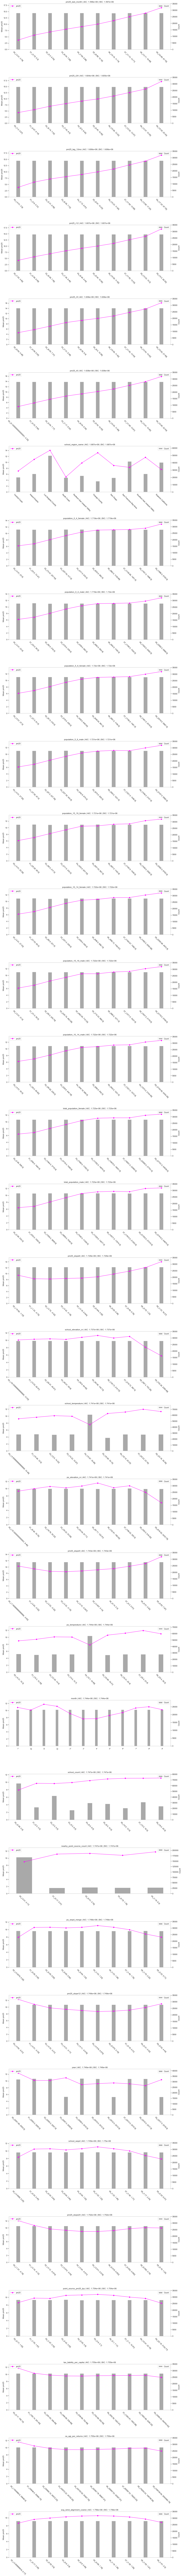

In [18]:
fs = FeatureStats(df_modeling)
var_list = x_vars_for_tree_model + instrument
# having issues w this var: 'tax_liability_per_capita'  
var_list2 = fs.sort_cat_features(var_list, yvar='pm25', max_factor_levels=10)
fs.plot_cat_features(var_list2['var'].to_list(), yvar='pm25', max_factor_levels=10)
print('')

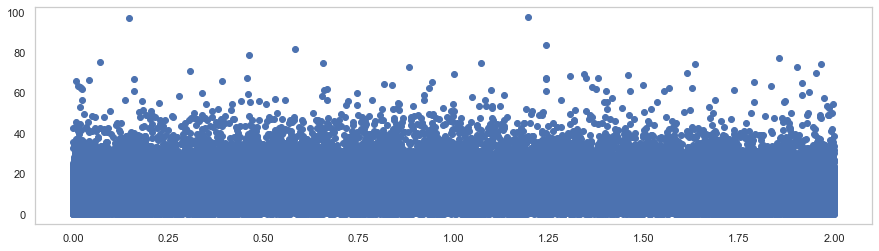

In [28]:
plt.scatter(df_modeling[instrument], df_modeling['pm25'])

Plots for the log scaled PM2.5 look the same.

# Correlation plots

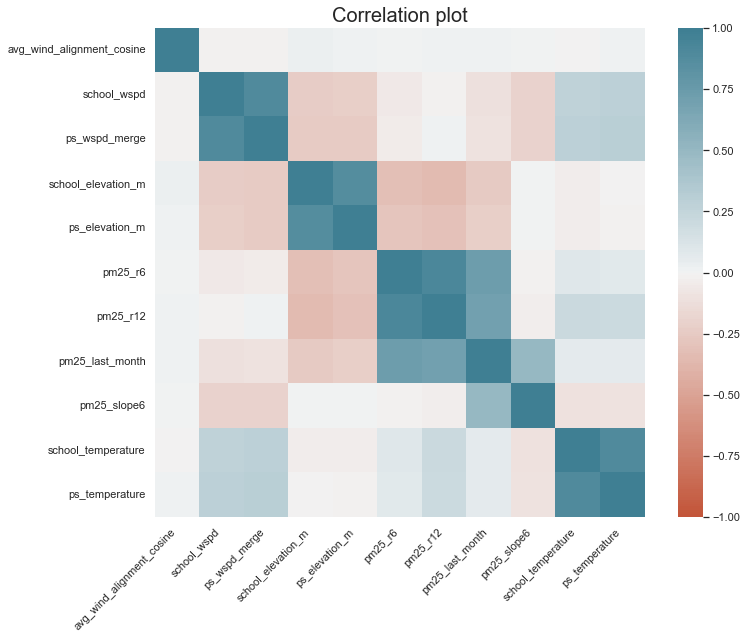

In [29]:
df_corr = df_modeling[instrument + ['school_wspd','ps_wspd_merge','school_elevation_m','ps_elevation_m', 'pm25_r6', 'pm25_r12', 
    'pm25_last_month', 'pm25_slope6', 'school_temperature', 'ps_temperature']].corr()

# plot the results
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(df_corr, vmin=-1, center=0, vmax=1, cmap=sns.diverging_palette(20, 220, n=200), square=True)

ax.set_xticklabels(ax.get_xticklabels(), 
    rotation=45, horizontalalignment='right')
ax.set_title("Correlation plot", fontdict = {"fontsize": 20})
print('')

# Aim 2 Regression = Predict pm2.5 levels

Predict the log

- QQplot says the residuals are not skewed, but have very heavy tails. 

                            OLS Regression Results                            
Dep. Variable:               pm25_log   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     9708.
Date:                Sun, 16 Oct 2022   Prob (F-statistic):               0.00
Time:                        20:32:56   Log-Likelihood:                -72870.
No. Observations:              277875   AIC:                         1.458e+05
Df Residuals:                  277821   BIC:                         1.464e+05
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

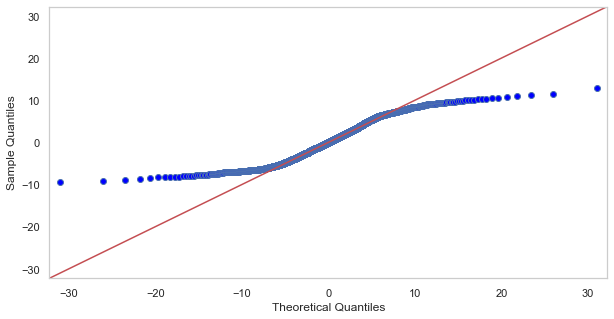

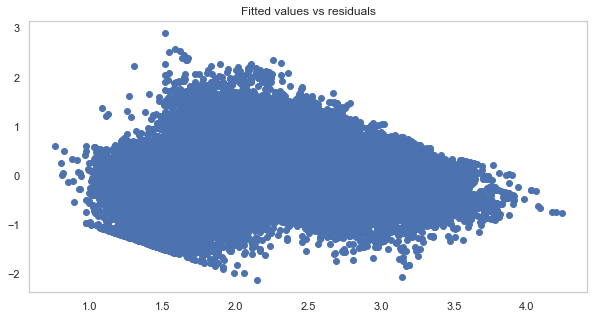

In [214]:
X = sm.add_constant(df_modeling[x_all + instrument])
y = df_modeling['pm25_log']
fit1 = sm.OLS(y, X).fit()

# add fitted y value to our dataset
df_modeling['yhat_pm25_log'] = fit1.fittedvalues.values
# resid
resids = fit1.resid

resids_and_fitted = pd.DataFrame({'resids': fit1.resid, 'fitted': fit1.fittedvalues.values})

print(fit1.summary())

# qqplot
import scipy.stats as stats
plt.rcParams["figure.figsize"] = (10,5)
fig = sm.qqplot(resids, stats.t, fit=True, line="45")
plt.show()

# resid vs fitted
plt.scatter(resids_and_fitted['fitted'], resids_and_fitted['resids'])
plt.title('Fitted values vs residuals')
plt.show()

<AxesSubplot:>

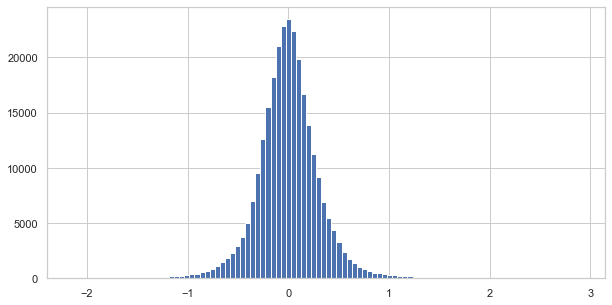

In [216]:
resids_and_fitted['resids'].hist(bins=100)

Predict pm2.5 non logged

                            OLS Regression Results                            
Dep. Variable:                   pm25   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     6830.
Date:                Sun, 16 Oct 2022   Prob (F-statistic):               0.00
Time:                        20:33:29   Log-Likelihood:            -7.6354e+05
No. Observations:              277875   AIC:                         1.527e+06
Df Residuals:                  277821   BIC:                         1.528e+06
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

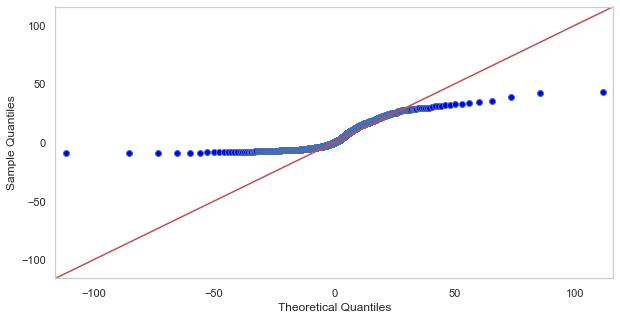

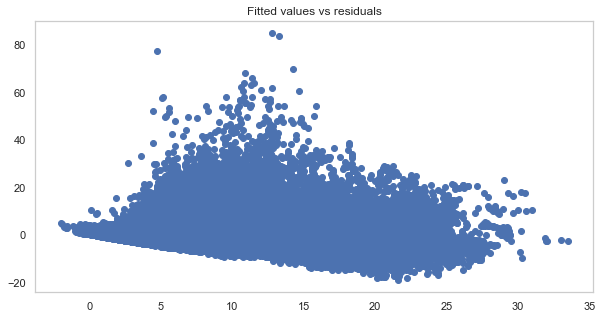

In [217]:
X = sm.add_constant(df_modeling[x_all + instrument])
y = df_modeling['pm25']
fit2 = sm.OLS(y, X).fit()

# add fitted y value to our dataset
df_modeling['yhat_pm25'] = fit2.fittedvalues.values
# resid
resids = fit2.resid

resids_and_fitted = pd.DataFrame({'resids': fit2.resid, 'fitted': fit2.fittedvalues.values})

print(fit2.summary())

# qqplot
import scipy.stats as stats
plt.rcParams["figure.figsize"] = (10,5)
fig = sm.qqplot(resids, stats.t, fit=True, line="45")
plt.show()

# resid vs fitted
plt.scatter(resids_and_fitted['fitted'], resids_and_fitted['resids'])
plt.title('Fitted values vs residuals')
plt.show()

<AxesSubplot:>

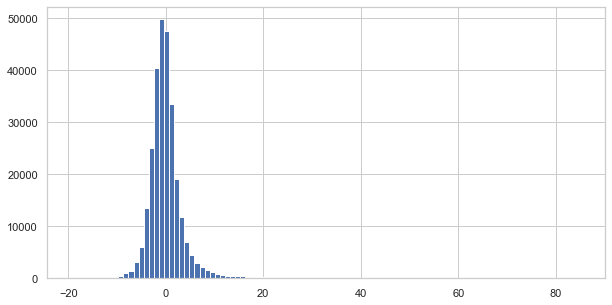

In [218]:
resids_and_fitted['resids'].hist(bins=100)

# Aim 3 Regression

- Stage 1 of the least squares regression: $\hat{x} = z \delta$.
  - $\hat{x}$ = Predicted pm2.5 amounts ($\hat{pm2.5}$). We'll use this predicted var to predict our final Y, health outcomes. 
  - $z$ = Instrument = `avg_wind_alignment_cosine`. But this right hand side of the equation should also include all other exogenous (x) vars. 
  
- Stage 2 of the equation: $\hat{y} = \hat{x} \beta$
  - $\hat{y}$ = predicted medical outcome
  - $\hat{x}$ = predicted pm2.5 amt from the first stage. But we also should include the other exogenous vars. 

Try the IV2SLS function from statsmodels first

In [167]:
y = df_modeling['y_hematopoietic']
X = df_modeling[x_all]
endog_var = df_modeling['pm25_log']
x_instrument = df_modeling['avg_wind_alignment_cosine']
X_and_instruments = df_modeling[x_all + ['avg_wind_alignment_cosine']]

iv_fit = IV2SLS(
  endog=y,
  exog=X,
  instrument=x_instrument
  ).fit()

print(iv_fit.summary())

                          IV2SLS Regression Results                           
Dep. Variable:        y_hematopoietic   R-squared:                   -1605.808
Model:                         IV2SLS   Adj. R-squared:              -1606.121
Method:                     Two Stage   F-statistic:                       nan
                        Least Squares   Prob (F-statistic):                nan
Date:                Sun, 16 Oct 2022                                         
Time:                        19:39:06                                         
No. Observations:              277875                                         
Df Residuals:                  277821                                         
Df Model:                          54                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

/Users/tj/opt/miniconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1817: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


Trying with alternative package

In [213]:
formula = 'y_hematopoietic' + ' ~ 1 + ' + '+'.join(x_all) + ' + [' + 'pm25_log~' + instrument[0] + ']'
iv_fit2 = IV2SLS_v2.from_formula(formula, data=df_modeling).fit(cov_type='unadjusted')
iv_fit2

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:        y_hematopoietic   R-squared:                     -0.1422
Estimator:                    IV-2SLS   Adj. R-squared:                -0.1424
No. Observations:              277875   F-statistic:                    588.38
Date:                Sun, Oct 16 2022   P-value (F-stat)                0.0000
Time:                        20:32:22   Distribution:                 chi2(53)
Cov. Estimator:            unadjusted                                         
                                                                              
                                               Parameter Estimates                                                
==================================================================================================================
                                                Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------------------------------------
Intercept                                         -0.0286     0.0024    -12.174     0.0000     -0.0332     -0.0240
ca_agi_per_returns                              -2.92e-10  9.679e-11    -3.0172     0.0026  -4.817e-10  -1.023e-10
month_02                                           0.0001   8.22e-05     1.5142     0.1300  -3.664e-05      0.0003
month_03                                           0.0003     0.0002     1.6115     0.1071  -6.608e-05      0.0007
month_04                                        4.965e-05  5.043e-05     0.9845     0.3249   -4.92e-05      0.0001
month_05                                          -0.0002     0.0001    -2.0964     0.0360     -0.0005  -1.601e-05
month_06                                          -0.0004     0.0002    -1.8622     0.0626     -0.0008   2.049e-05
month_07                                          -0.0006     0.0003    -1.7460     0.0808     -0.0013   7.296e-05
month_08                                          -0.0006     0.0003    -1.8206     0.0687     -0.0012   4.296e-05
month_09                                          -0.0003     0.0002    -1.9425     0.0521     -0.0006    2.89e-06
month_10                                          -0.0002  2.634e-05    -7.0399     0.0000     -0.0002     -0.0001
month_11                                          -0.0002     0.0001    -1.9195     0.0549     -0.0004   4.555e-06
month_12                                       -6.552e-05  3.843e-05    -1.7050     0.0882     -0.0001   9.797e-06
nearby_point_source_count                      -6.036e-05  1.815e-05    -3.3256     0.0009  -9.594e-05  -2.479e-05
pm25_lag_12mo                                   2.323e-05  1.208e-05     1.9222     0.0546  -4.563e-07   4.691e-05
pm25_last_month                                -3.329e-05   1.73e-05    -1.9247     0.0543  -6.719e-05   6.091e-07
pm25_r12                                           0.0008     0.0005     1.6833     0.0923     -0.0001      0.0017
pm25_r24                                        3.803e-05   1.48e-05     2.5698     0.0102   9.026e-06   6.704e-05
pm25_r6                                           -0.0003     0.0002    -1.6458     0.0998     -0.0006   5.125e-05
pm25_r9                                           -0.0008     0.0004    -1.7452     0.0809     -0.0016   9.346e-05
pm25_slope12                                       0.0033     0.0019     1.7356     0.0826     -0.0004      0.0069
pm25_slope24                                       0.0009     0.0005     1.6858     0.0918     -0.0001      0.0020
pm25_slope6                                       -0.0003     0.0002    -1.6538     0.0982     -0.0006   4.703e-05
pm25_slope9                                       -0.0010     0.0006    -1.7210     0.0852     -0.0020      0.0001
point_source_pm25_tpy                           -2.25e-07  1.061e-07    -2.1215     0.0339  -4.

In [220]:
formula = 'y_vasculitis' + ' ~ 1 + ' + '+'.join(x_all) + ' + [' + 'pm25_log~' + instrument[0] + ']'
iv_fit2 = IV2SLS_v2.from_formula(formula, data=df_modeling).fit(cov_type='unadjusted')
iv_fit2

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:           y_vasculitis   R-squared:                     -0.1555
Estimator:                    IV-2SLS   Adj. R-squared:                -0.1557
No. Observations:              277875   F-statistic:                    492.03
Date:                Sun, Oct 16 2022   P-value (F-stat)                0.0000
Time:                        20:43:31   Distribution:                 chi2(53)
Cov. Estimator:            unadjusted                                         
                                                                              
                                               Parameter Estimates                                                
==================================================================================================================
                                                Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------------------------------------
Intercept                                         -0.0145     0.0015    -9.6623     0.0000     -0.0175     -0.0116
ca_agi_per_returns                             -2.589e-12  6.185e-11    -0.0419     0.9666  -1.238e-10   1.186e-10
month_02                                       -7.525e-05  5.252e-05    -1.4328     0.1519     -0.0002   2.769e-05
month_03                                          -0.0002     0.0001    -1.7721     0.0764     -0.0005   2.276e-05
month_04                                       -5.904e-05  3.222e-05    -1.8323     0.0669     -0.0001   4.115e-06
month_05                                           0.0001  7.495e-05     1.4953     0.1348  -3.483e-05      0.0003
month_06                                           0.0002     0.0001     1.5893     0.1120  -4.964e-05      0.0005
month_07                                           0.0004     0.0002     1.6313     0.1028   -7.16e-05      0.0008
month_08                                           0.0003     0.0002     1.5485     0.1215  -8.105e-05      0.0007
month_09                                           0.0002     0.0001     1.5268     0.1268  -4.572e-05      0.0004
month_10                                          -0.0001  1.683e-05    -8.4736     0.0000     -0.0002     -0.0001
month_11                                           0.0001   7.19e-05     1.6240     0.1044  -2.416e-05      0.0003
month_12                                        2.418e-05  2.456e-05     0.9846     0.3248  -2.395e-05   7.231e-05
nearby_point_source_count                       3.005e-06   1.16e-05     0.2591     0.7956  -1.973e-05   2.574e-05
pm25_lag_12mo                                  -1.213e-05  7.721e-06    -1.5712     0.1161  -2.726e-05   3.002e-06
pm25_last_month                                 1.781e-05  1.105e-05     1.6118     0.1070  -3.848e-06   3.947e-05
pm25_r12                                          -0.0005     0.0003    -1.7925     0.0731     -0.0011    5.06e-05
pm25_r24                                        1.231e-05  9.457e-06     1.3022     0.1929  -6.221e-06   3.085e-05
pm25_r6                                            0.0002     0.0001     1.6920     0.0906  -2.792e-05      0.0004
pm25_r9                                            0.0005     0.0003     1.7374     0.0823  -6.189e-05      0.0010
pm25_slope12                                      -0.0021     0.0012    -1.7464     0.0807     -0.0044      0.0003
pm25_slope24                                      -0.0006     0.0003    -1.6855     0.0919     -0.0013   9.591e-05
pm25_slope6                                        0.0002  9.814e-05     1.7213     0.0852  -2.343e-05      0.0004
pm25_slope9                                        0.0006     0.0004     1.7524     0.0797  -7.359e-05      0.0013
point_source_pm25_tpy                           2.854e-08  6.777e-08     0.4211     0.6737  -1.

In [221]:
formula = 'y_diabetes' + ' ~ 1 + ' + '+'.join(x_all) + ' + [' + 'pm25_log~' + instrument[0] + ']'
iv_fit2 = IV2SLS_v2.from_formula(formula, data=df_modeling).fit(cov_type='unadjusted')
iv_fit2

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:             y_diabetes   R-squared:                     -0.0412
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0414
No. Observations:              277875   F-statistic:                    250.65
Date:                Sun, Oct 16 2022   P-value (F-stat)                0.0000
Time:                        20:43:49   Distribution:                 chi2(53)
Cov. Estimator:            unadjusted                                         
                                                                              
                                               Parameter Estimates                                                
==================================================================================================================
                                                Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------------------------------------
Intercept                                         -0.0430     0.0060    -7.1651     0.0000     -0.0547     -0.0312
ca_agi_per_returns                              8.127e-10  2.467e-10     3.2945     0.0010   3.292e-10   1.296e-09
month_02                                          -0.0001     0.0002    -0.6945     0.4874     -0.0006      0.0003
month_03                                          -0.0004     0.0005    -0.8695     0.3846     -0.0014      0.0005
month_04                                       -7.343e-05     0.0001    -0.5712     0.5678     -0.0003      0.0002
month_05                                           0.0003     0.0003     0.9686     0.3327     -0.0003      0.0009
month_06                                           0.0005     0.0005     1.0035     0.3156     -0.0005      0.0016
month_07                                           0.0008     0.0009     0.9657     0.3342     -0.0009      0.0025
month_08                                           0.0009     0.0008     1.1350     0.2564     -0.0006      0.0024
month_09                                           0.0005     0.0004     1.0783     0.2809     -0.0004      0.0013
month_10                                       -9.146e-05  6.714e-05    -1.3622     0.1731     -0.0002   4.013e-05
month_11                                           0.0004     0.0003     1.3335     0.1824     -0.0002      0.0009
month_12                                        9.294e-05  9.795e-05     0.9488     0.3427  -9.904e-05      0.0003
nearby_point_source_count                       2.727e-05  4.626e-05     0.5895     0.5555   -6.34e-05      0.0001
pm25_lag_12mo                                  -9.406e-06   3.08e-05    -0.3054     0.7601  -6.977e-05   5.096e-05
pm25_last_month                                 3.196e-05  4.408e-05     0.7249     0.4685  -5.444e-05      0.0001
pm25_r12                                          -0.0011     0.0012    -0.9180     0.3586     -0.0035      0.0013
pm25_r24                                         -1.1e-05  3.772e-05    -0.2915     0.7707  -8.493e-05   6.294e-05
pm25_r6                                            0.0004     0.0004     0.8618     0.3888     -0.0005      0.0012
pm25_r9                                            0.0010     0.0011     0.9373     0.3486     -0.0011      0.0032
pm25_slope12                                      -0.0044     0.0048    -0.9101     0.3627     -0.0137      0.0050
pm25_slope24                                      -0.0014     0.0014    -1.0084     0.3133     -0.0041      0.0013
pm25_slope6                                        0.0004     0.0004     0.9077     0.3640     -0.0004      0.0011
pm25_slope9                                        0.0014     0.0014     0.9638     0.3352     -0.0014      0.0041
point_source_pm25_tpy                           3.979e-07  2.703e-07     1.4719     0.1410  -1.

# Two stage regression manually

                            OLS Regression Results                            
Dep. Variable:        y_hematopoietic   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     12.71
Date:                Sun, 16 Oct 2022   Prob (F-statistic):          3.00e-108
Time:                        20:47:38   Log-Likelihood:             1.2903e+06
No. Observations:              277875   AIC:                        -2.580e+06
Df Residuals:                  277821   BIC:                        -2.580e+06
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

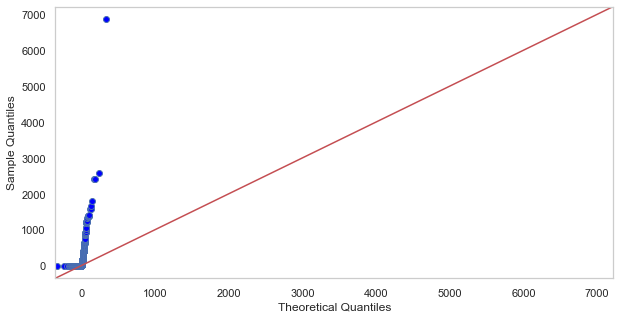

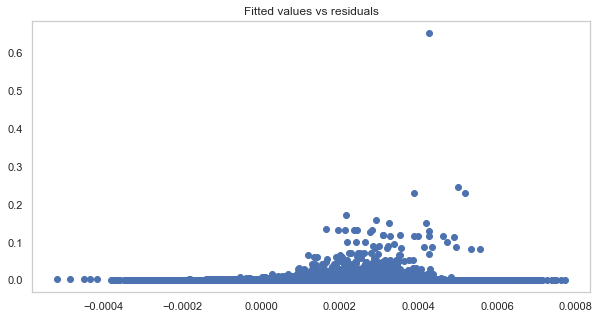

In [223]:
X = sm.add_constant(df_modeling[x_all + ['yhat_pm25']])
y = df_modeling['y_hematopoietic']
fit2 = sm.OLS(y, X).fit()

# add fitted y value to our dataset
#df_modeling['yhat_pm25'] = fit2.fittedvalues.values
# resid
resids = fit2.resid

resids_and_fitted = pd.DataFrame({'resids': fit2.resid, 'fitted': fit2.fittedvalues.values})

print(fit2.summary())

# qqplot
import scipy.stats as stats
plt.rcParams["figure.figsize"] = (10,5)
fig = sm.qqplot(resids, stats.t, fit=True, line="45")
plt.show()

# resid vs fitted
plt.scatter(resids_and_fitted['fitted'], resids_and_fitted['resids'])
plt.title('Fitted values vs residuals')
plt.show()

# Modeling with more complex relationship. 

Now, model $\hat{x}$ using a more complex ML algo such as xgb. Then use that $\hat{x}$ in the 2nd stage least squares regression. 